# 206 Optimizers

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* matplotlib

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [180]:
LR = 0.04
BATCH_SIZE = 50
EPOCH = 13

### Generate some fake data

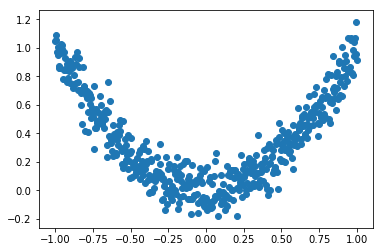

In [181]:
# fake dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 500), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))
#y = 0.25 * x + 0.68 + 0.1*torch.normal(torch.zeros(*x.size()))

# plot dataset
plt.scatter(x.numpy(), y.numpy())
plt.show()

### Put dataset into torch dataset

In [182]:
torch_dataset = Data.TensorDataset(data_tensor=x, target_tensor=y)
loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

### Default network

In [183]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # hidden layer
        self.predict = torch.nn.Linear(20, 1)   # output layer
        torch.nn.init.constant(self.predict.weight,0)
        torch.nn.init.constant(self.predict.bias,0.)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

### Different nets

In [184]:
net_SGD         = Net()
net_Momentum    = Net()
net_Nesterov    = Net()
net_RMSprop     = Net()
net_Adam        = Net()
nets = [net_SGD, net_Momentum, net_Nesterov, net_RMSprop, net_Adam]

### Different optimizers

In [185]:
opt_SGD      = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_Nesterov = torch.optim.SGD(net_Nesterov.parameters(), lr=LR, momentum=0.9, nesterov=True)
opt_RMSprop  = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam     = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers   = [opt_SGD, opt_Momentum, opt_Nesterov, opt_RMSprop, opt_Adam]

In [186]:
loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], [], []]   # record loss
ws_his = [[],[],[],[],[]] # record w
bs_his = [[],[],[],[],[]] # record b

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12


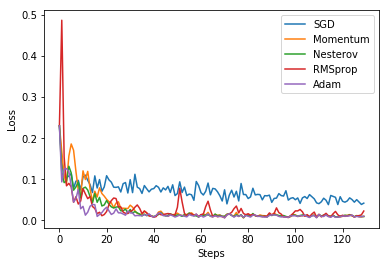

In [187]:
# training
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (batch_x, batch_y) in enumerate(loader):          # for each training step
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        for net, opt, l_his, w_his, b_his in zip(nets, optimizers, losses_his, ws_his, bs_his):
            output = net(b_x)              # get output for every net
            loss = loss_func(output, b_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()                     # apply gradients
            l_his.append(loss.data[0])     # loss recoder
            w = net.predict.weight.data.numpy()[0,0]
            w_his.append(w)
            b = net.predict.bias.data.numpy()[0]
            b_his.append(b)

labels = ['SGD', 'Momentum', 'Nesterov', 'RMSprop', 'Adam']
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i])
#for i, (w_his, b_his) in enumerate(zip(ws_his,bs_his)):
#    plt.scatter(b_his,w_his,label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
#plt.ylim((0, 1.0))
plt.show()